In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from stable_baselines3 import PPO
import torch as th
from environment import RNAInvEnvironment
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import RNA
from RNA_helper import bracket_to_bonds, secundary_structures_metric, get_initial_guess

In [39]:
objective_structure = '(((((((((((((((.(((((.((.....)).((.....)).((.....)).((.....)).((.....)).))))).(((.....))).(((((.((.....)).((.....)).((.....)).((.....)).((.....)).))))).(((.....))).(((((.((.....)).((.....)).((.....)).((.....)).((.....)).))))).(((.....))).(((((.((.....)).((.....)).((.....)).((.....)).((.....)).))))).(((.....))).(((((.((.....)).((.....)).((.....)).((.....)).((.....)).))))).)))))))))))))))'

solution = 'GCGCGGCCCGCCCCCACCCCCAGGGAAAACCAGGGAAAACCACCGAAAAGGAGCGAAAAGCAGCGAAAAGCAGGGGGACGGGAAAACCGAGCCGCACCGAAAAGGACCGAAAAGGAGGGAAAACCAGCGAAAAGCAGCGAAAAGCAGCGGCAGCCGAAAAGGCACGCGCACCGAAAAGGAGGGAAAACCAGGGAAAACCAGCGAAAAGCAGCGAAAAGCAGCGCGAGGGGAAAACCCAGGGCCACCGAAAAGGACCGAAAAGGAGGGAAAACCAGCGAAAAGCAGCGAAAAGCAGGCCCAGCGGAAAACGCACCGGCAGGGAAAACCAGGGAAAACCACCGAAAAGGAGCGAAAAGCAGCGAAAAGCAGCCGGAGGGGGCGGGCCGCGC'
len(objective_structure)

389

In [40]:
objective_structure = '(((((((....(((...........)))((((((((..(((((((((((((((((((...(((((......))))).)))))).)))))))))))))..))))))))..)))))))'
len(objective_structure)

116

In [21]:
env = RNAInvEnvironment(objective_structure=objective_structure, max_steps=1, tuple_obs_space=True, metric_type='distance')
# env = RNAInvEnvironment(objective_structure=objective_structure, max_steps=1, tuple_obs_space=True, metric_type='energy')

In [22]:
# model = PPO.load('models/embiddings_complex_bandit_distance/best_model.zip')
model = PPO.load('models/easy_test/best_model.zip')

# model = PPO.load('models/embiddings_diff/best_model.zip')
embedding_layer = model.policy.features_extractor.base_embeding

In [23]:
RNA.eval_structure_simple(solution, objective_structure)

100000.0

In [24]:
s, e = RNA.fold(solution)
s == objective_structure, e

(False, -154.60000610351562)

In [25]:
env.inv_bases_dict, env.bases_list

({'G': 0, 'U': 1, 'A': 2, 'C': 3}, array(['G', 'U', 'A', 'C'], dtype='<U1'))

In [26]:
for p in embedding_layer.parameters():
    print(p)

Parameter containing:
tensor([[-1.0354, -2.0424,  0.8648],
        [ 1.0626,  0.6916,  0.5779],
        [ 1.0538, -1.2376,  0.5964],
        [-1.6901,  2.3085, -1.2513]], device='cuda:0', requires_grad=True)


In [27]:
# Parameter containing:
# tensor([[-1.5807,  1.8137],
#         [ 0.7974,  0.2230],
#         [ 0.6633, -1.0696],
#         [-0.3978, -0.7225]], device='cuda:0', requires_grad=True)

In [28]:
vectors = p.detach().cpu().numpy()

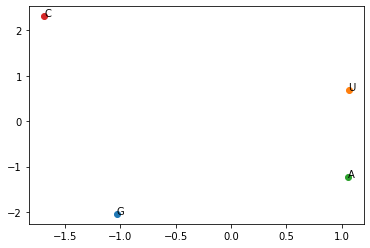

In [29]:
for i in range(len(vectors)):
    plt.scatter(vectors[i,0], vectors[i,1])
    plt.text(vectors[i,0], vectors[i,1], env.bases_list[i])

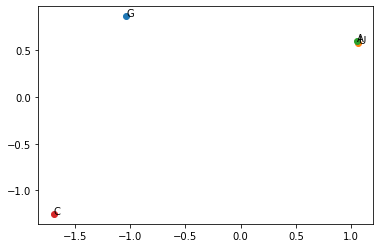

In [30]:
for i in range(len(vectors)):
    plt.scatter(vectors[i,0], vectors[i,2])
    plt.text(vectors[i,0], vectors[i,2], env.bases_list[i])

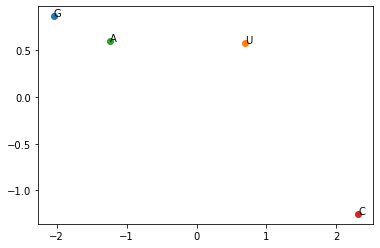

In [31]:
for i in range(len(vectors)):
    plt.scatter(vectors[i,1], vectors[i,2])
    plt.text(vectors[i,1], vectors[i,2], env.bases_list[i])

In [32]:
infos = []
for i in range(1_000):
    obs = env.reset()
    action = model.predict(obs, deterministic=False)[0]
    state, energy_reward, done, info = env.step(action)
    infos.append(info)
    print(f'\r{i}, {info["structure_distance"]}', end='')

16, 0.918918918918919CACCCUUACAUGCACAACAAACAUAUGCCAAUAUCACACCCUUGUGCCGAAGUGAUUAUCAGGCCAACUGAGGCCUAAAUCACUUUCGGCAUAAGGGCAUGAUAUUGAAAAGGGUG
21, 0.9594594594594594CCCGGCGAAAAGAUAACUCAGUACAAUCGAUGAAAACAUCUAGGUGCUUCUUCUCCGCCCGGACUCUUGCUGGUCCACGGGGAUGGAAGCGCUUGGAGCUUUUCAUCAACGCCGGG
72, 0.918918918918919CGUACGAACUAGGGAAAUAUCAAUACCCAGCGCGGGCAAAUCUGGUUUCGACCAGGCAACCAUUCCGCAUAGAAUGAGUUUGGAUCGAGGUCGGGUUAUCUCGCGCUAAUCGUACG
80, 0.972972972972973CUCGUCUAGAAGCGCAAAACCACAACGCAAGCUAGCCUGGAGCAGGGCGUUCGUCUACUCGAAGCCUCGCUGCUUCCUGGGCGUAGUGCCCUGCUUUUAGCUAGUUUAAGGACGAG
83, 0.972972972972973GCAGGGGAAAAGCCAGAUAAGAACAGGCGAGUCAGUCCGGCCAAUGUGGGGGCUUACCCCGACGUGGGUUAACGUCCGUAGGCAUCUCGUGUUGGUCAAAUUGAUUCAACCCCUGC
102, 0.918918918918919CGCAGAUAUAUCCGAAGUUCUAACACGGGCGGCAUGAAGCCUUAGGGUGUGGAGUGAAAACACUAAGGUAAUGGUGAUCACUUAUACAUUCUAAGGCGACAUGUCGUCAAUCUGCG
103, 1.0GCUGCAUACAAGACAGCAAAAUCAAGUCCUCCGGGGGAUAUGCGUACUGGGACUGUCAAAUUGAAAGACAAUUCAAAGGCAGUAUCCAGUACGCGUGAAUCUCGGAGACAUGCAGC
104, 1.0GUUGCGUAAAAGACAUAUUAUUCCCGUCGGACCCUCC

In [33]:
df = pd.DataFrame(infos)

In [34]:
df.head()

,free_energy,folding_struc,structure_distance,energy_to_objective,energy_reward,distance_reward
0,-63.000000,(((((((....((((.........))))((((((((..((((((((...,0.945946,-58.900002,30.200001,0.391892
1,-57.500000,((((((((...((((.........))))((((((((..((((((((...,0.810811,-51.200001,8.299999,-0.054054
2,-52.299999,(((((((...((((.(........)))))(((((((..((((((((...,0.945946,-51.099998,26.599998,0.216216
3,-57.099998,(((((((....((((.........))))((((((((..((((((((...,0.945946,-55.400002,29.000002,0.324324
4,-60.900002,(((((((....(((...........)))((((((((..((((((((...,0.972973,-60.900002,30.000002,0.229730


In [35]:
df.corr()

,free_energy,structure_distance,energy_to_objective,energy_reward,distance_reward
free_energy,1.000000,0.037254,0.922264,-0.569629,0.033452
structure_distance,0.037254,1.000000,-0.207088,0.177335,0.465320
energy_to_objective,0.922264,-0.207088,1.000000,-0.639663,-0.074852
energy_reward,-0.569629,0.177335,-0.639663,1.000000,0.310006
distance_reward,0.033452,0.465320,-0.074852,0.310006,1.000000


In [36]:
df.describe()

,free_energy,structure_distance,energy_to_objective,energy_reward,distance_reward
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-59.560500,0.920351,-56.258600,22.026800,0.238392
std,7.269058,0.063765,7.094853,10.398025,0.141157
min,-80.099998,0.635135,-74.099998,-14.399998,-0.175676
25%,-64.500000,0.891892,-61.099998,14.899998,0.148649
50%,-59.700001,0.945946,-56.549999,21.700001,0.229730
75%,-54.700001,0.972973,-51.400002,29.324999,0.324324
max,-35.500000,1.000000,-32.299999,52.100002,0.918919


array([[<AxesSubplot:title={'center':'energy_to_objective'}>]],
      dtype=object)

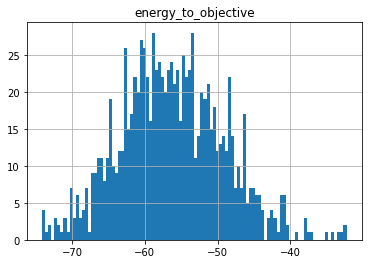

In [37]:
df.hist('energy_to_objective', bins=100)

array([[<AxesSubplot:title={'center':'structure_distance'}>]],
      dtype=object)

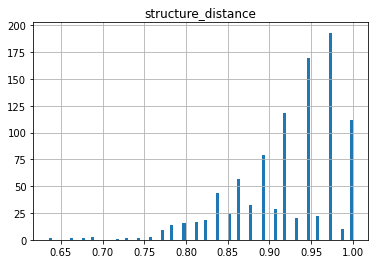

In [38]:
df.hist('structure_distance', bins=100)

array([[<AxesSubplot:title={'center':'structure_distance'}>]],
      dtype=object)

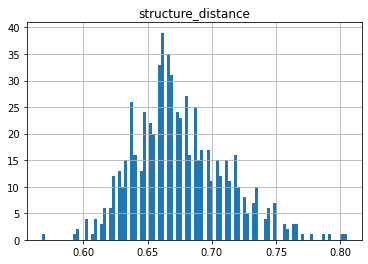

In [65]:
df.hist('structure_distance', bins=100)

# Random Sample

In [102]:
infos_random = []
for i in range(10_000):
    obs = env.reset()
    action = model.predict(obs, deterministic=False)[0]
    state, energy_reward, done, info = env.step(action)
    infos_random.append(info)
    print(f'\r{i}, {info["structure_distance"]}', end='')

9999, 0.7874564459930313

In [103]:
df_random = pd.DataFrame(infos_random)

In [104]:
df_random.describe()

,free_energy,structure_distance,energy_to_objective,energy_reward,distance_reward
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-74.775430,0.790602,-3.868590,38.221880,0.499266
std,6.606853,0.031145,7.775464,14.358768,0.046634
min,-104.500000,0.599303,-30.700001,-14.800000,0.222997
25%,-79.239998,0.777003,-9.100000,28.500001,0.470383
50%,-74.699997,0.797909,-3.900000,38.200001,0.501742
75%,-70.387499,0.811847,1.400000,47.900001,0.529617
max,-47.849998,0.846690,25.900000,93.099998,0.665505


array([[<AxesSubplot:title={'center':'energy_to_objective'}>]],
      dtype=object)

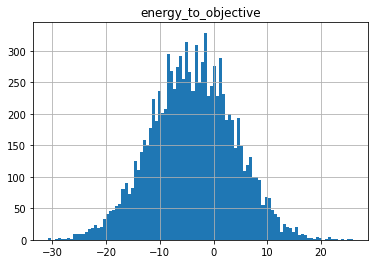

In [105]:
df_random.hist('energy_to_objective', bins=100)

array([[<AxesSubplot:title={'center':'structure_distance'}>]],
      dtype=object)

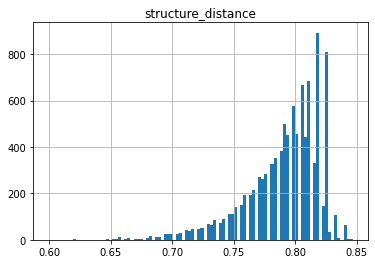

In [106]:
df_random.hist('structure_distance', bins=100)

# Static

In [52]:
infos_static = []
obs = env.reset()
for i in range(1000):
    action = model.predict(obs, deterministic=False)[0]
    state, energy_reward, done, info = env.step(action)
    infos_static.append(info)
    print(f'\r{i}', end='')

999

In [458]:
df_static = pd.DataFrame(infos_static)

In [459]:
df_static.describe()

,free_energy,structure_distance,energy_to_objective,energy_reward,distance_reward
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-251.552999,0.402195,-145.968000,1.910000,0.001254
std,11.536594,0.046853,3.406229,19.483380,0.067062
min,-279.299988,0.296167,-154.399994,-11.100006,-0.149826
25%,-257.475006,0.368467,-148.500000,-3.549999,-0.045296
50%,-250.449997,0.402439,-146.050003,0.250008,-0.003484
75%,-245.324997,0.432056,-143.674999,3.850002,0.052265
max,-217.399994,0.519164,-138.500000,188.199993,0.184669


array([[<AxesSubplot:title={'center':'energy_to_objective'}>]],
      dtype=object)

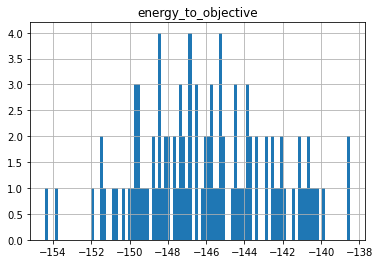

In [460]:
df_static.hist('energy_to_objective', bins=100)

array([[<AxesSubplot:title={'center':'structure_distance'}>]],
      dtype=object)

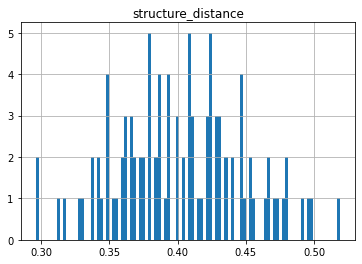

In [461]:
df_static.hist('structure_distance', bins=100)

In [346]:
np.mean(energy_rewards), np.max(energy_rewards), np.min(energy_rewards)
# (176.43799975156784, 207.6999969482422, 147.19999384880066)

(43.143000091612336, 76.5, 3.1999998092651367)

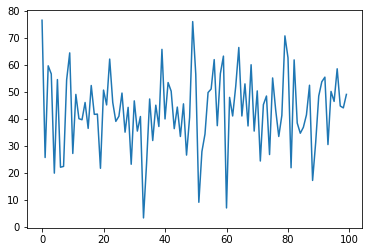

In [347]:
plt.plot(energy_rewards)

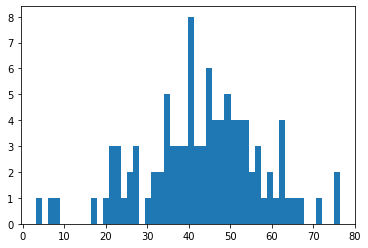

In [348]:
_ = plt.hist(energy_rewards, bins=50)

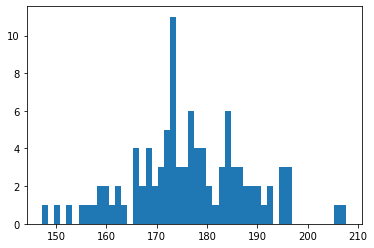

In [338]:
_ = plt.hist(energy_rewards, bins=50)

In [305]:

obs = env.reset()
done = False
energy_rewards = []
i = 0
while not done:
    i = i + 1
    action = model.predict(obs, deterministic=False)[0]
    state, energy_reward, done, info = env.step(action)
    energy_rewards.append(energy_reward)
    print(f'\r{i}, {np.sum(energy_rewards)}', end='')

1, 5.0

In [290]:
np.mean(energy_rewards)*512, np.max(energy_rewards), np.min(energy_rewards)

(30.90000057220459, 52.899999141693115, -49.50000190734863)

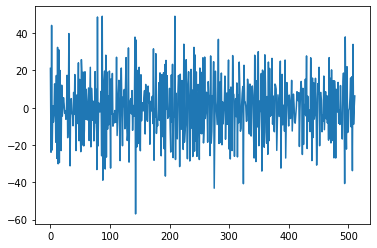

In [283]:
plt.plot(energy_rewards)

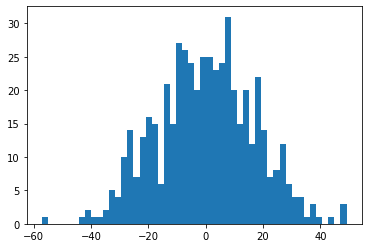

In [286]:
_ = plt.hist(energy_rewards, bins=50)

In [271]:
np.sum(energy_rewards), len(energy_rewards)

(-8.09999942779541, 512)

# Solutions analysis

In [160]:
f = open('sequences_learned.txt', 'r')

In [161]:
sequences = f.readlines()

In [162]:
f.close()

In [165]:
sequences = [s.strip() for s in sequences]

In [169]:
free_energies = []
for s in sequences:
    sec_struct, free_energy = RNA.fold(s)
    free_energies.append(free_energy)

In [173]:
np.mean(free_energies), np.std(free_energies), np.min(free_energies), np.max(free_energies)

(-71.18100975670333, 9.245043974447311, -95.0, -34.20000076293945)